# Waterbodies

* **Products used:** [DE Africa Waterbodies](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html)

## Background

The DE Africa Waterbodies Historical Extent product is a static polygon-based view of the DE Africa Water Observations from Space All-Time Summary product. The historical extent represents where water has appeared in at least 5% of clear observations since 1987. It is not a capture of a water body’s true extent in any given year, but a record of where water has appeared since 1987. To be captured in the dataset, polygons must have an area of at least 4,500 metres squared (5 Landsat pixels). The historical extent polygons have been derived from the [DE Africa Water Observations from Space All-Time Summary](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html#WOfS-All-Time-Summary) product, which provides historical surface water observations across the African continent.

For each water body, the Surface Area Change product provides the percentage of the historical extent that was classified as wet, dry, or invalid, for each [DE Africa Water Observation from Space Feature Layer](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html#WOfS-Feature-Layer) scene that captured the water body. This can be used to identify when water bodies are increasing or decreasing in wet surface area.

**Disclaimer: DE Africa Waterbodies Surface Area Change measures the wet surface area of waterbodies as estimated from satellites. This product does not measure depth, volume, purpose of the waterbody, nor the source of the water.**

### Applications 

* Identify and analyse persistent and seasonal water bodies 
* Water resource management 
* Gain insights into the severity and spatial distribution of drought

## Description
This notebook will demonstrate how to load historical extents and wet surface area timeseries from the [DE Africa Waterbodies service](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html). 

Topics covered include:

1. Getting a list of available polygons in a given area
2. Select and plot a single polygon
3. Plotting the surface area of the polygon over time

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the “Load packages” cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import matplotlib.pyplot as plt
import datacube
import numpy as np
import xarray as xr

from deafrica_tools.plotting import display_map
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.waterbodies import (
    get_geohashes,
    get_waterbodies,
    get_waterbody,
    get_time_series,
)

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="wbvis")

## Analysis parameters

This section defines the analysis parameters, including:

* `lat`, `lon`, `buffer`: center lat/lon and analysis window size for the area of interest (in degrees)

The default area is a water body in Mauritania.

In [3]:
# Set the central latitude and longitude
lat = -20.52
lon = 22.72

# Set the buffer to load around the central coordinates
buffer = 0.3

# Compute the bounding box coordinates
xlim = (lon-buffer, lon+buffer)
ylim =  (lat+buffer, lat-buffer)

# Preview area on a map
display_map(xlim, ylim)

## Getting data

The `deafrica_waterbodies` module allows you to query water bodies by location or geohash.

### List waterbody polygons in an area
We can get a list of waterbody polygons inside a bounding box of coordinates using `get_waterbodies`.

In [4]:
# Create a bounding box from study area coordinates
bbox = (xlim[0], ylim[1], xlim[1], ylim[0])

# Select all water bodies located within the bounding box
polygons = get_waterbodies(bbox, crs="EPSG:4326")

In [5]:
# Return GeoDataFrame with selected water bodies
polygons

,id,area_m2,length_m,UID,WB_ID,perim_m,timeseries,geometry
0,DEAfrica_Waterbodies.184145,86400.0,572.108717,kkrfx8e23b,184144,1800,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.48175 -20.64927, 22.48268 -..."
1,DEAfrica_Waterbodies.256240,32400.0,180.000244,ks246b7vrs,256239,720,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.62539 -20.69519, 22.62726 -..."
2,DEAfrica_Waterbodies.256241,63900.0,552.380597,ks24sj36gg,256240,1620,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.67701 -20.62243, 22.67732 -..."
3,DEAfrica_Waterbodies.256242,207900.0,720.000000,ks24yfnmb3,256241,2280,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.80480 -20.59509, 22.80511 -..."
4,DEAfrica_Waterbodies.256243,9000.0,161.275929,ks24yfykdw,256242,540,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.80480 -20.59384, 22.80542 -..."
...,...,...,...,...,...,...,...,...
60,DEAfrica_Waterbodies.256302,24300.0,299.918901,ks2ke78gef,256301,1260,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.99539 -20.28216, 22.99633 -..."
61,DEAfrica_Waterbodies.256303,18000.0,233.345281,ks2ke7mugg,256302,840,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((23.00192 -20.28341, 23.00317 -..."
62,DEAfrica_Waterbodies.256304,18900.0,360.624458,ks2kee3rw2,256303,1200,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((23.00659 -20.28216, 23.00690 -..."
63,DEAfrica_Waterbodies.256305,7200.0,150.000000,ks2keec64c,256304,420,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((23.00690 -20.28116, 23.00721 -..."


The returned geodataframe includes all the water bodies which are located within the bounding box. This dataset contains metadata for each water body in the dataset, including the ID, UID, WB_UID, area, perimeter and time series. See the [Waterbodies Historical Extent documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html#Waterbodies-Historical-Extent) for descriptions of each attribute.

### Displaying the polygons

Once the water body polygons are in memory, you can plot them directly, or explore them in an interactive window.

<Axes: >

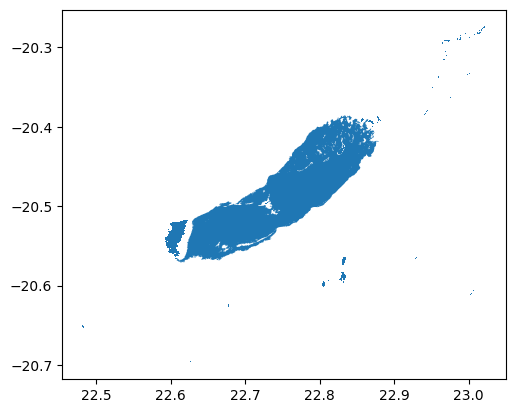

In [6]:
# Plot the waterbody polygons located within the bounding box
polygons.plot()

In [7]:
# Explore the waterbody polygons located within the bounding box
polygons.explore()

#### Geohashes
Every water body in DE Africa Water Bodies has a unique identifier (UID) called a [_geohash_](https://en.wikipedia.org/wiki/Geohash). The geohash of a water body is derived from its position, and this process can be reversed to obtain the location from the geohash. A waterbody's geohash is contained under the UID attribute and can be obtained through [DE Africa Maps](https://maps.digitalearth.africa/) by clicking on a waterbody.

**Note:** You might notice that these polygons have a range of similar geohash prefixes ('edyg' or 'edz'). If two geohashes have a similar prefix, this means that they are close together.

### Getting data for a specific water body

We can use the `.explore()` function above to interactively explore the subset of water bodies located within the bounding box. Hovering over a water body will display its attributes, including the water body's geohash (UID). After noting the geohash from the `.explore()` function, we can use it to extract just that water body through the `get_waterbody()` function.

By default, try the geohash `edyq3kwze`.

In [8]:
selected_waterbody_geohash = "ks25mz2682"

selected_waterbody = get_waterbody(selected_waterbody_geohash)
selected_waterbody

,id,area_m2,length_m,UID,WB_ID,perim_m,timeseries,geometry
0,DEAfrica_Waterbodies.256251,2.016837e+08,32661.910154,ks25mz2682,256250,313800,https://deafrica-services.s3.af-south-1.amazon...,"MULTIPOLYGON (((22.83309 -20.38556, 22.83340 -..."


#### Plot the selected water body

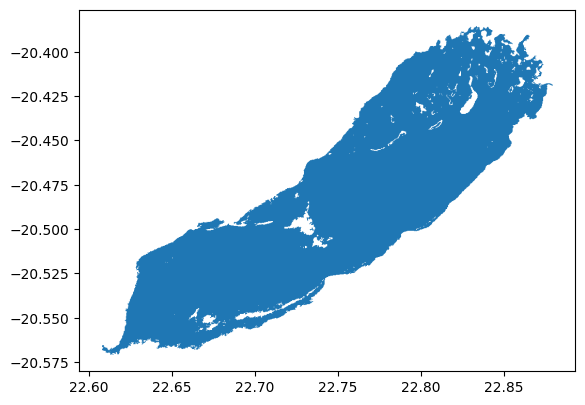

In [9]:
selected_waterbody.plot();

## Load DEM

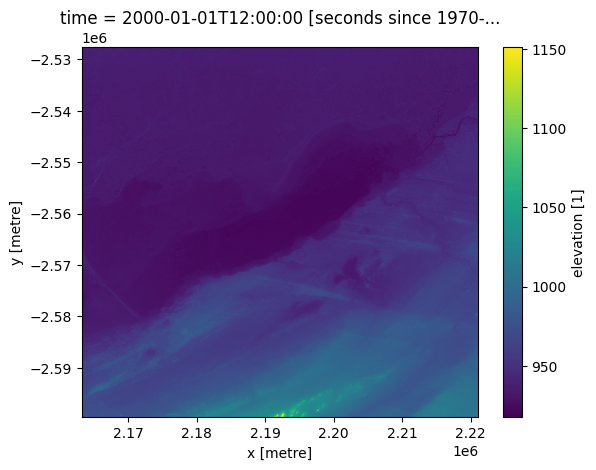

In [10]:
res = (-30,30)

query = {
    'x': xlim,
    'y': ylim,
    'resolution':res,
    'output_crs': 'epsg:6933',
    'measurements':'elevation'
}

#load the dem 30 m product
dem = dc.load(product="dem_cop_30", **query).squeeze()
dem.elevation.plot()

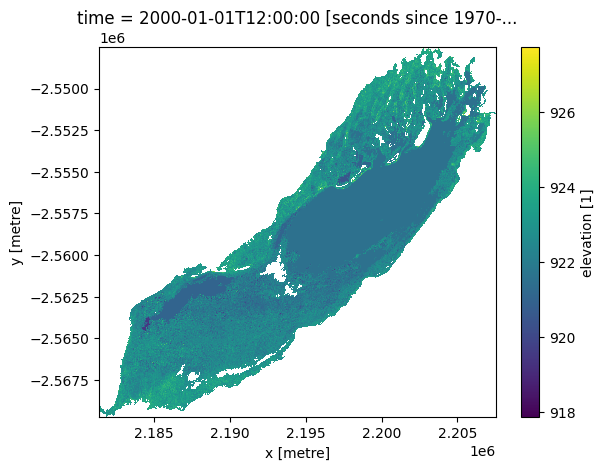

In [11]:
wb_rast = xr_rasterize(selected_waterbody, dem, crs='EPSG:6933')
dem = dem.where(wb_rast, drop=True)
dem.elevation.plot();

In [12]:
minElev = dem.elevation.min()
maxElev = dem.elevation.max()
print('Min bottom elevation %.2f m., max bottom elevation %.2f m.'%(minElev,maxElev))

Min bottom elevation 917.87 m., max bottom elevation 927.73 m.


In [13]:
# steps for calculation
nSteps = 20

# lake bottom elevation intervals
elevSteps = np.round(np.linspace(minElev,maxElev,nSteps),2)
elevSteps

array([917.87, 918.39, 918.91, 919.43, 919.95, 920.47, 920.98, 921.5 ,
       922.02, 922.54, 923.06, 923.58, 924.1 , 924.62, 925.14, 925.66,
       926.18, 926.7 , 927.21, 927.73])

In [14]:
lakeBottom = dem.elevation.to_numpy()
lakeRst = dem.elevation

In [15]:
# definition of volume function
def calculateVol(elevStep,elevDem,lakeRst):
    tempDem = elevStep - elevDem[elevDem<elevStep]
    tempVol = tempDem.sum()*np.abs(res[0])*np.abs(res[1])
    return tempVol
# calculate volumes for each elevation
volArray = []
for elev in elevSteps:
    tempVol = calculateVol(elev,lakeBottom,lakeRst)
    volArray.append(tempVol)

print("Lake bottom elevations %s"%elevSteps)
volArrayMCM = [round(i/1000000,2) for i in volArray]
print("Lake volume in million of cubic meters %s"%volArrayMCM)

Lake bottom elevations [917.87 918.39 918.91 919.43 919.95 920.47 920.98 921.5  922.02 922.54
 923.06 923.58 924.1  924.62 925.14 925.66 926.18 926.7  927.21 927.73]
Lake volume in million of cubic meters [0.0, 0.0, 0.0, 0.01, 0.1, 0.25, 0.72, 5.28, 43.87, 97.91, 173.18, 265.19, 366.21, 470.25, 574.97, 679.8, 784.67, 889.55, 992.4, 1097.27]


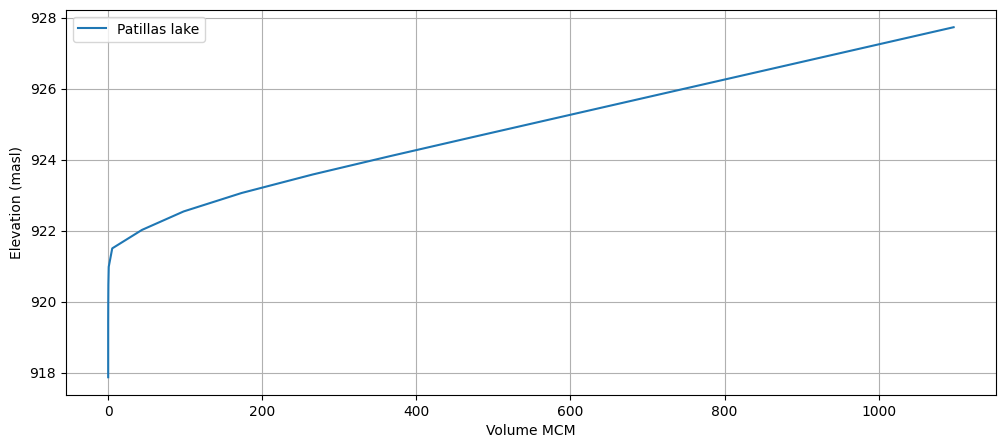

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(volArrayMCM,elevSteps,label='Patillas lake')
ax.grid()
ax.legend()
ax.set_xlabel('Volume MCM')
ax.set_ylabel('Elevation (masl)')
plt.show()

In [17]:
dem

<xarray.Dataset>
Dimensions:      (y: 740, x: 873)
Coordinates:
    time         datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 -2.548e+06 -2.548e+06 ... -2.57e+06 -2.57e+06
  * x            (x) float64 2.181e+06 2.181e+06 ... 2.208e+06 2.208e+06
    spatial_ref  int32 6933
Data variables:
    elevation    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

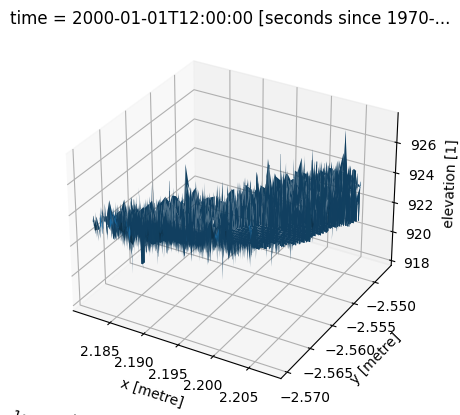

In [18]:
dem.elevation.plot.surface()